## Import

In [84]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [85]:
%reload_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config

In [86]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

# features
store_features = f'../data/{provider}/features.h5'

## Pre processing

### Load Data

In [87]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

INFO:soccer_xg.api:Loading datasets


### Load Features

In [88]:
features = []
labels = []
# load features and labels for each season
for (l,s) in itertools.product(leagues, seasons):
    try:
        features.append(pd.read_hdf(store_features, key=f'{l}/{s}/features'))
        labels.append(pd.read_hdf(store_features, key=f'{l}/{s}/labels'))
    except KeyError:
        print(f"Key not found for league {l} and season {s}")
features = pd.concat(features)
labels = pd.concat(labels)
# filter open play shots
open_play_idx = features[features.type_id_a0 == 'shot'].index
features = features.loc[open_play_idx]
labels = labels.loc[open_play_idx]

display(features.head())
display(labels.to_frame().head())

type_id_a0      type_id_a1 type_id_a2 bodypart_id_a0  \
game_id action_id                                                        
2500098 17              shot         dribble      cross           foot   
        40              shot  corner_crossed       pass           foot   
        77              shot       clearance      cross           foot   
        140             shot           cross    dribble           foot   
        145             shot            pass       pass           foot   

                  bodypart_id_a1 bodypart_id_a2 result_id_a1 result_id_a2  \
game_id action_id                                                           
2500098 17                  foot           foot      success      success   
        40                  foot           foot      success         fail   
        77                  foot           foot         fail         fail   
        140                 foot           foot      success      success   
        145                 foot           foot      success      success   

                   start_x_a0  start_y_a0  ...  speed_a02  shot_angle_a0  \
game_id action_id                          ...                             
2500098 17              99.75       26.52  ...   1.319750       0.499778   
        40              91.35       35.36  ...   4.249364       0.517985   
        77              75.60       29.92  ...   5.874066       0.242481   
        140             92.40       43.52  ...   2.061543       0.371538   
        145             99.75       37.40  ...   1.289870       0.978291   

                   shot_angle_a1  shot_angle_a2  caley_zone_a0  caley_zone_a1  \
game_id action_id                                                               
2500098 17              0.483780       0.065500              2              3   
        40              0.000000       0.363334              3              8   
        77              0.491555       0.043863              6              3   
        140             0.134860       0.167545              4              5   
        145             0.654611       0.320841              1              3   

                   caley_zone_a2  angle_zone_a0  angle_zone_a1  angle_zone_a2  
game_id action_id                                                              
2500098 17                     8              9             12             18  
        40                     4             12             21             12  
        77                     0             18             12             18  
        140                    0             12             15             18  
        145                    4              6              9             15  

[5 rows x 59 columns]

goal
game_id action_id       
2500098 17         False
        40         False
        77         False
        140        False
        145        False

In [89]:
features.dtypes

type_id_a0                category
type_id_a1                category
type_id_a2                category
bodypart_id_a0            category
bodypart_id_a1            category
bodypart_id_a2            category
result_id_a1              category
result_id_a2              category
start_x_a0                 float64
start_y_a0                 float64
start_x_a1                 float64
start_y_a1                 float64
start_x_a2                 float64
start_y_a2                 float64
end_x_a1                   float64
end_y_a1                   float64
end_x_a2                   float64
end_y_a2                   float64
dx_a1                      float64
dy_a1                      float64
movement_a1                float64
dx_a2                      float64
dy_a2                      float64
movement_a2                float64
dx_a01                     float64
dy_a01                     float64
mov_a01                    float64
dx_a02                     float64
dy_a02              

### Split train and test 

In [90]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [91]:
# Get all numerical features
NUM = features.select_dtypes(include=['float64']).columns.tolist()

# Get all categorical features
CAT = features.select_dtypes(include=['object', 'category']).columns.tolist()

# Now you have arrays of all numerical and categorical features
print("Numerical features:", NUM)
print("Categorical features:", CAT)

Numerical features: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Categorical features: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']


In [92]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

INFO:soccer_xg.api:Loading `games` data


In [93]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (20652, 59)
--------------------
dataset = val
shape = (7781, 59)
--------------------
dataset = test
shape = (11965, 59)
--------------------


## Learning 

### Logistic regression

In [94]:
%autoreload 2
from soccer_xg.ml import logreg

In [95]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
import logging

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import scipy.sparse as sp
from scipy import stats
from sklearn import clone
from sklearn.base import BaseEstimator, TransformerMixin



class ColumnsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        assert isinstance(columns, list)
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]
    

class AsString(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x.astype(str)
def simple_proc_for_linear_algoritms(numeric_features, categoric_features):
    """
    Create a simple preprocessing pipeline for linear algorithms
    """

    catpipe = make_pipeline(
        ColumnsSelector(categoric_features),
        AsString(),
        ce.OneHotEncoder()
        # ColumnApplier(FillNaN('nan')),
        # ColumnApplier(TolerantLabelEncoder())
    )
    numpipe = make_pipeline(
        ColumnsSelector(numeric_features),
        SimpleImputer(strategy='mean'),
        #StandardScaler(),
        MinMaxScaler() # Chi squared test
    )
    if numeric_features and categoric_features:
        return make_union(catpipe, numpipe)
    elif numeric_features:
        return numpipe
    elif categoric_features:
        return catpipe
    raise Exception('Both variable lists are empty')

# Configure logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

class FeatureSelector:
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def transform(self, X):
        return X[:, self.feature_indices]

    def fit(self, X, y=None):
        return self  

def logreg_gridsearch_model(
    numeric_features,
    categoric_features,
    n_iter=100,
    scoring='roc_auc',
    k_best=40
):
    """
    Logistic regression pipeline with feature selection and hyperparameter tuning.
    """
    param_space = {
        'clf__C': np.logspace(-5, 5, 100),
        'clf__class_weight': ['balanced', None],
    }

    chi2_selector = SelectKBest(score_func=chi2, k=k_best)

    pipe = Pipeline(
        [
            ('preprocessing', simple_proc_for_linear_algoritms(
                numeric_features, categoric_features)),
            ('chi2_selection', chi2_selector),
            ('clf', LogisticRegression(max_iter=10000, fit_intercept=False)),
        ]
    )

    return RandomizedSearchCV(
        pipe, param_space, n_iter=n_iter, scoring=scoring, cv=5
    )

In [96]:
search_logreg = logreg_gridsearch_model(
    numeric_features=NUM,
    categoric_features=CAT,
    scoring='neg_brier_score',
    n_iter=1000,
    k_best=80 
)

In [97]:
search_logreg.fit(X_train, y_train)

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 200 is smaller than n_iter=1000. Running 200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessing',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('pipeline-1',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('columnsselector',
                                                                                               ColumnsSelector(columns=['type_id_a0',
                                                                                                                        'type_id_a1',
                                                                                                                        'type_id_a2',
                                                                

In [98]:
search_logreg.best_score_

-0.07887378022707729

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (y_pred[y_true])[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:135: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\visualisation.py:135: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().legend()
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning

{'max_dev': 98.96093942513288, 'residual_area': 739.8659865509825, 'roc': 0.79157463465807, 'brier': 0.0828160185077036, 'ece': 0.005450049212619299, 'ace': 0.008715575502266617, 'fig': <Figure size 720x360 with 3 Axes>}


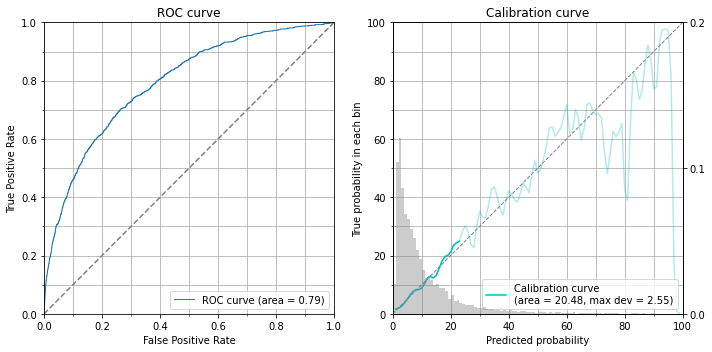

In [99]:
model = xg.OpenplayXGModel()
model.model = search_logreg.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
#model.save_model(f'{provider}_openplay_logreg_basic_chi_square') -0.0798722999951742

In [100]:
search_logreg.best_estimator_['clf']

LogisticRegression(C=5.72236765935022, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [101]:
index_cat = []
for col in CAT:
    value_counts = features[col].value_counts()

    non_zero_counts = value_counts[value_counts > 1]

    for i in range(len(non_zero_counts)):
        index_cat.append(col)

index_features = index_cat + NUM
print(len(index_features))

144


In [102]:
# Access the 'preprocessing' step
preprocessing = model.model.named_steps['preprocessing']

# Access the 'columnsselector' step inside the pipeline
columns_selector = preprocessing.transformer_list[0][1].named_steps['columnsselector']

# Check which columns are selected
selected_columns = columns_selector.columns
print("Selected Columns:", selected_columns)

Selected Columns: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']


In [103]:
model.model.named_steps['clf'].coef_[0]

array([ 0.34316223,  0.18188456, -0.60306352,  0.58880001,  0.21270282,
        0.01186568, -0.48981021, -1.73300737,  0.10699856,  0.1521632 ,
        0.29837646,  0.31119162, -0.35207294, -0.1382937 , -0.40164518,
        1.86829212, -1.11092664, -1.71562153,  0.38076871,  1.09455748,
        0.25597449, -0.55762496, -0.5211391 , -0.55223852, -0.8632796 ,
       -0.66475755, -0.03515618, -0.36353948,  0.36301831,  0.36816891,
        0.09585672,  0.20461611, -0.21219124,  0.12974727,  0.11435904,
       -0.02473918,  0.26102916,  0.20732635, -0.1162296 , -0.29976998,
        0.03665266,  0.09563223, -0.02500965,  0.11177745,  0.39150516,
       -1.2245242 , -0.78966205, -1.43472325, -0.87332923, -0.95103539,
       -1.33267878, -1.50041708, -1.03565925,  0.58819608,  0.57224145,
        0.48794518,  0.58925968,  0.44561357,  0.46669603,  0.12267497,
        0.40569758, -0.08080561, -0.06941286, -0.02227534, -0.07755989,
       -0.33038712,  0.40535748,  0.17994188,  2.14589675, -2.08

In [104]:
chi2_selector = model.model.named_steps['chi2_selection']
selected_mask = chi2_selector.get_support()
print("Number of features selected by SelectKBest:", selected_mask)

Number of features selected by SelectKBest: [False  True False False  True  True False  True  True  True  True False
 False False  True False  True False False  True False  True  True False
 False False  True False  True  True False False False  True  True  True
  True False  True False False False False  True False False False  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True  True  True  True  True False  True False  True
  True  True  True  True  True  True False False False False False  True
 False  True False False False False False False False False False False
 False False False  True False  True  True False False  True False  True
  True False False False False False False False False  True  True  True]


In [105]:
k = 0 
feat = []
for i in selected_mask:
    k += 1
    if i:
        print(f"Feature {k}: {index_features[k - 1]}")
        feat.append(index_features[k - 1])

Feature 2: type_id_a1
Feature 5: type_id_a1
Feature 6: type_id_a1
Feature 8: type_id_a1
Feature 9: type_id_a1
Feature 10: type_id_a1
Feature 11: type_id_a1
Feature 15: type_id_a1
Feature 17: type_id_a2
Feature 20: type_id_a2
Feature 22: type_id_a2
Feature 23: type_id_a2
Feature 27: type_id_a2
Feature 29: type_id_a2
Feature 30: type_id_a2
Feature 34: type_id_a2
Feature 35: bodypart_id_a0
Feature 36: bodypart_id_a0
Feature 37: bodypart_id_a1
Feature 39: bodypart_id_a1
Feature 44: result_id_a1
Feature 48: caley_zone_a0
Feature 49: caley_zone_a0
Feature 50: caley_zone_a0
Feature 51: caley_zone_a0
Feature 52: caley_zone_a0
Feature 53: caley_zone_a0
Feature 54: caley_zone_a0
Feature 55: caley_zone_a0
Feature 56: caley_zone_a0
Feature 57: caley_zone_a1
Feature 58: caley_zone_a1
Feature 60: caley_zone_a1
Feature 61: caley_zone_a1
Feature 62: caley_zone_a1
Feature 63: caley_zone_a1
Feature 65: caley_zone_a1
Feature 66: caley_zone_a2
Feature 67: caley_zone_a2
Feature 69: caley_zone_a2
Feature 70

In [106]:
#model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic')


(pd.DataFrame(
    data={'importance': model.model.named_steps['clf'].coef_[0]},index=feat)
    .sort_values(by='importance')) # .to_csv("feature_importance/feature_importance_chi_square_test_6.csv")

,importance
start_dist_to_goal_a0,-5.480070
end_dist_to_goal_a1,-2.471914
end_x_a1,-2.086154
type_id_a1,-1.733007
bodypart_id_a0,-1.715622
...,...
angle_zone_a1,0.589260
bodypart_id_a1,1.094557
type_id_a2,1.868292
start_x_a0,2.145897
